In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [3]:
def borehole_plots(df, parameter, c):
    borehole_list = df["PointID"].unique()
    bh = 0
    fig, axes = plt.subplots(3, 4)
    fig.suptitle(f'Distribution of {parameter} by geological layers', size=30, x=0.5, y=0.92)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)
    sns.set(rc={"figure.figsize":(20, 27)})
    sns.set(font_scale=1) 
    for row in range(3):
        for col in range(4):
            if bh >= len(borehole_list):
                pass
            else:
                filtered_df = df[df["PointID"] == borehole_list[bh]]
                ax = sns.stripplot(data=filtered_df, x=parameter, y="Index", ax=axes[row, col], orient="h", color=c, 
                                   jitter=False, s=10, marker="D", linewidth=1, alpha=.1)
                ax = sns.boxplot(data=filtered_df, x=parameter, y="Index", ax=axes[row, col], orient="h", boxprops=dict(alpha=.7), linewidth=1, showfliers= False)
                ax.set_title(borehole_list[bh], size=16)
                ax.set_ylabel("Layers")
                bh += 1

## Import Su from raw gINT data

In [40]:
sample, depth, su, test = [], [], [], []
su_dict = {
    "LPEN" : "LPEN_PPEN",
    "TORV":"TORV_PUSS",
    "UU":"TRIT_CU",
    "CU":"TRET_SHST",
    "DSS":"DSST_FSHS"}

for test_type in su_dict:
    df = pd.read_excel("data/gint export_310724_su.xlsx", test_type)
    if test_type == "CU":
        cu_test_type = df["Test type"].to_list()
    # Add id, su and tests into respective lists
    for i in range(len(df)):
        if test_type == "CU" and df["Test type"][i] != "CID":
            test.append(df["Test type"][i])
            sample.append(df["PointID"][i][:13])
            depth.append(df["Depth"][i])
            su.append(abs(df[su_dict[test_type]][i]))    # use abs here because some Su from CAUe are negative
        elif test_type == "UU" or test_type == "DSS":
            sample.append(df["PointID"][i][:13])
            depth.append(df["Depth"][i])
            su.append(abs(df[su_dict[test_type]][i]))    # use abs here because some Su from CAUe are negative
            test.append(test_type)
        else:
            pass

su_df = pd.DataFrame(list(zip(sample, depth, su, test)), columns=["PointID", "Depth", "Su", "Test"])
su_df

,PointID,Depth,Su,Test
0,544WTG23-BH01,11.60,203.30,UU
1,544WTG23-BH01,24.70,188.90,UU
2,544WTG23-BH01,25.40,188.40,UU
3,544WTG23-BH01,25.41,93.70,UU
4,544WTG23-BH01,34.70,76.33,UU
...,...,...,...,...
90,544WTG23-BH01,3.70,29.00,DSS
91,544WTG23-BH03,18.50,32.00,DSS
92,544WTG23-BH05,2.00,6.00,DSS
93,544WTG23-BH06,14.00,40.00,DSS


In [38]:
cpt_df = pd.read_excel("data/CPT parameter.xlsx")
geo_df = pd.read_excel("data/BD profile.xlsx")

,PointID,Depth,Su,Test
0,1,11.60,203.30,UU
1,1,24.70,188.90,UU
2,1,25.40,188.40,UU
3,1,25.41,93.70,UU
4,1,34.70,76.33,UU
...,...,...,...,...
90,1,3.70,29.00,DSS
91,3,18.50,32.00,DSS
92,5,2.00,6.00,DSS
93,6,14.00,40.00,DSS


# Calculate Su for different Nkt values

In [49]:
cpt_df["Su (Nkt 10)"] = (cpt_df["qnet (kPa)"] - cpt_df["σv (kPa)"]) / 10
cpt_df["Su (Nkt 20)"] =  (cpt_df["qnet (kPa)"] - cpt_df["σv (kPa)"]) / 20
cpt_df["Su (Nkt 40)"] =  (cpt_df["qnet (kPa)"] - cpt_df["σv (kPa)"]) / 40

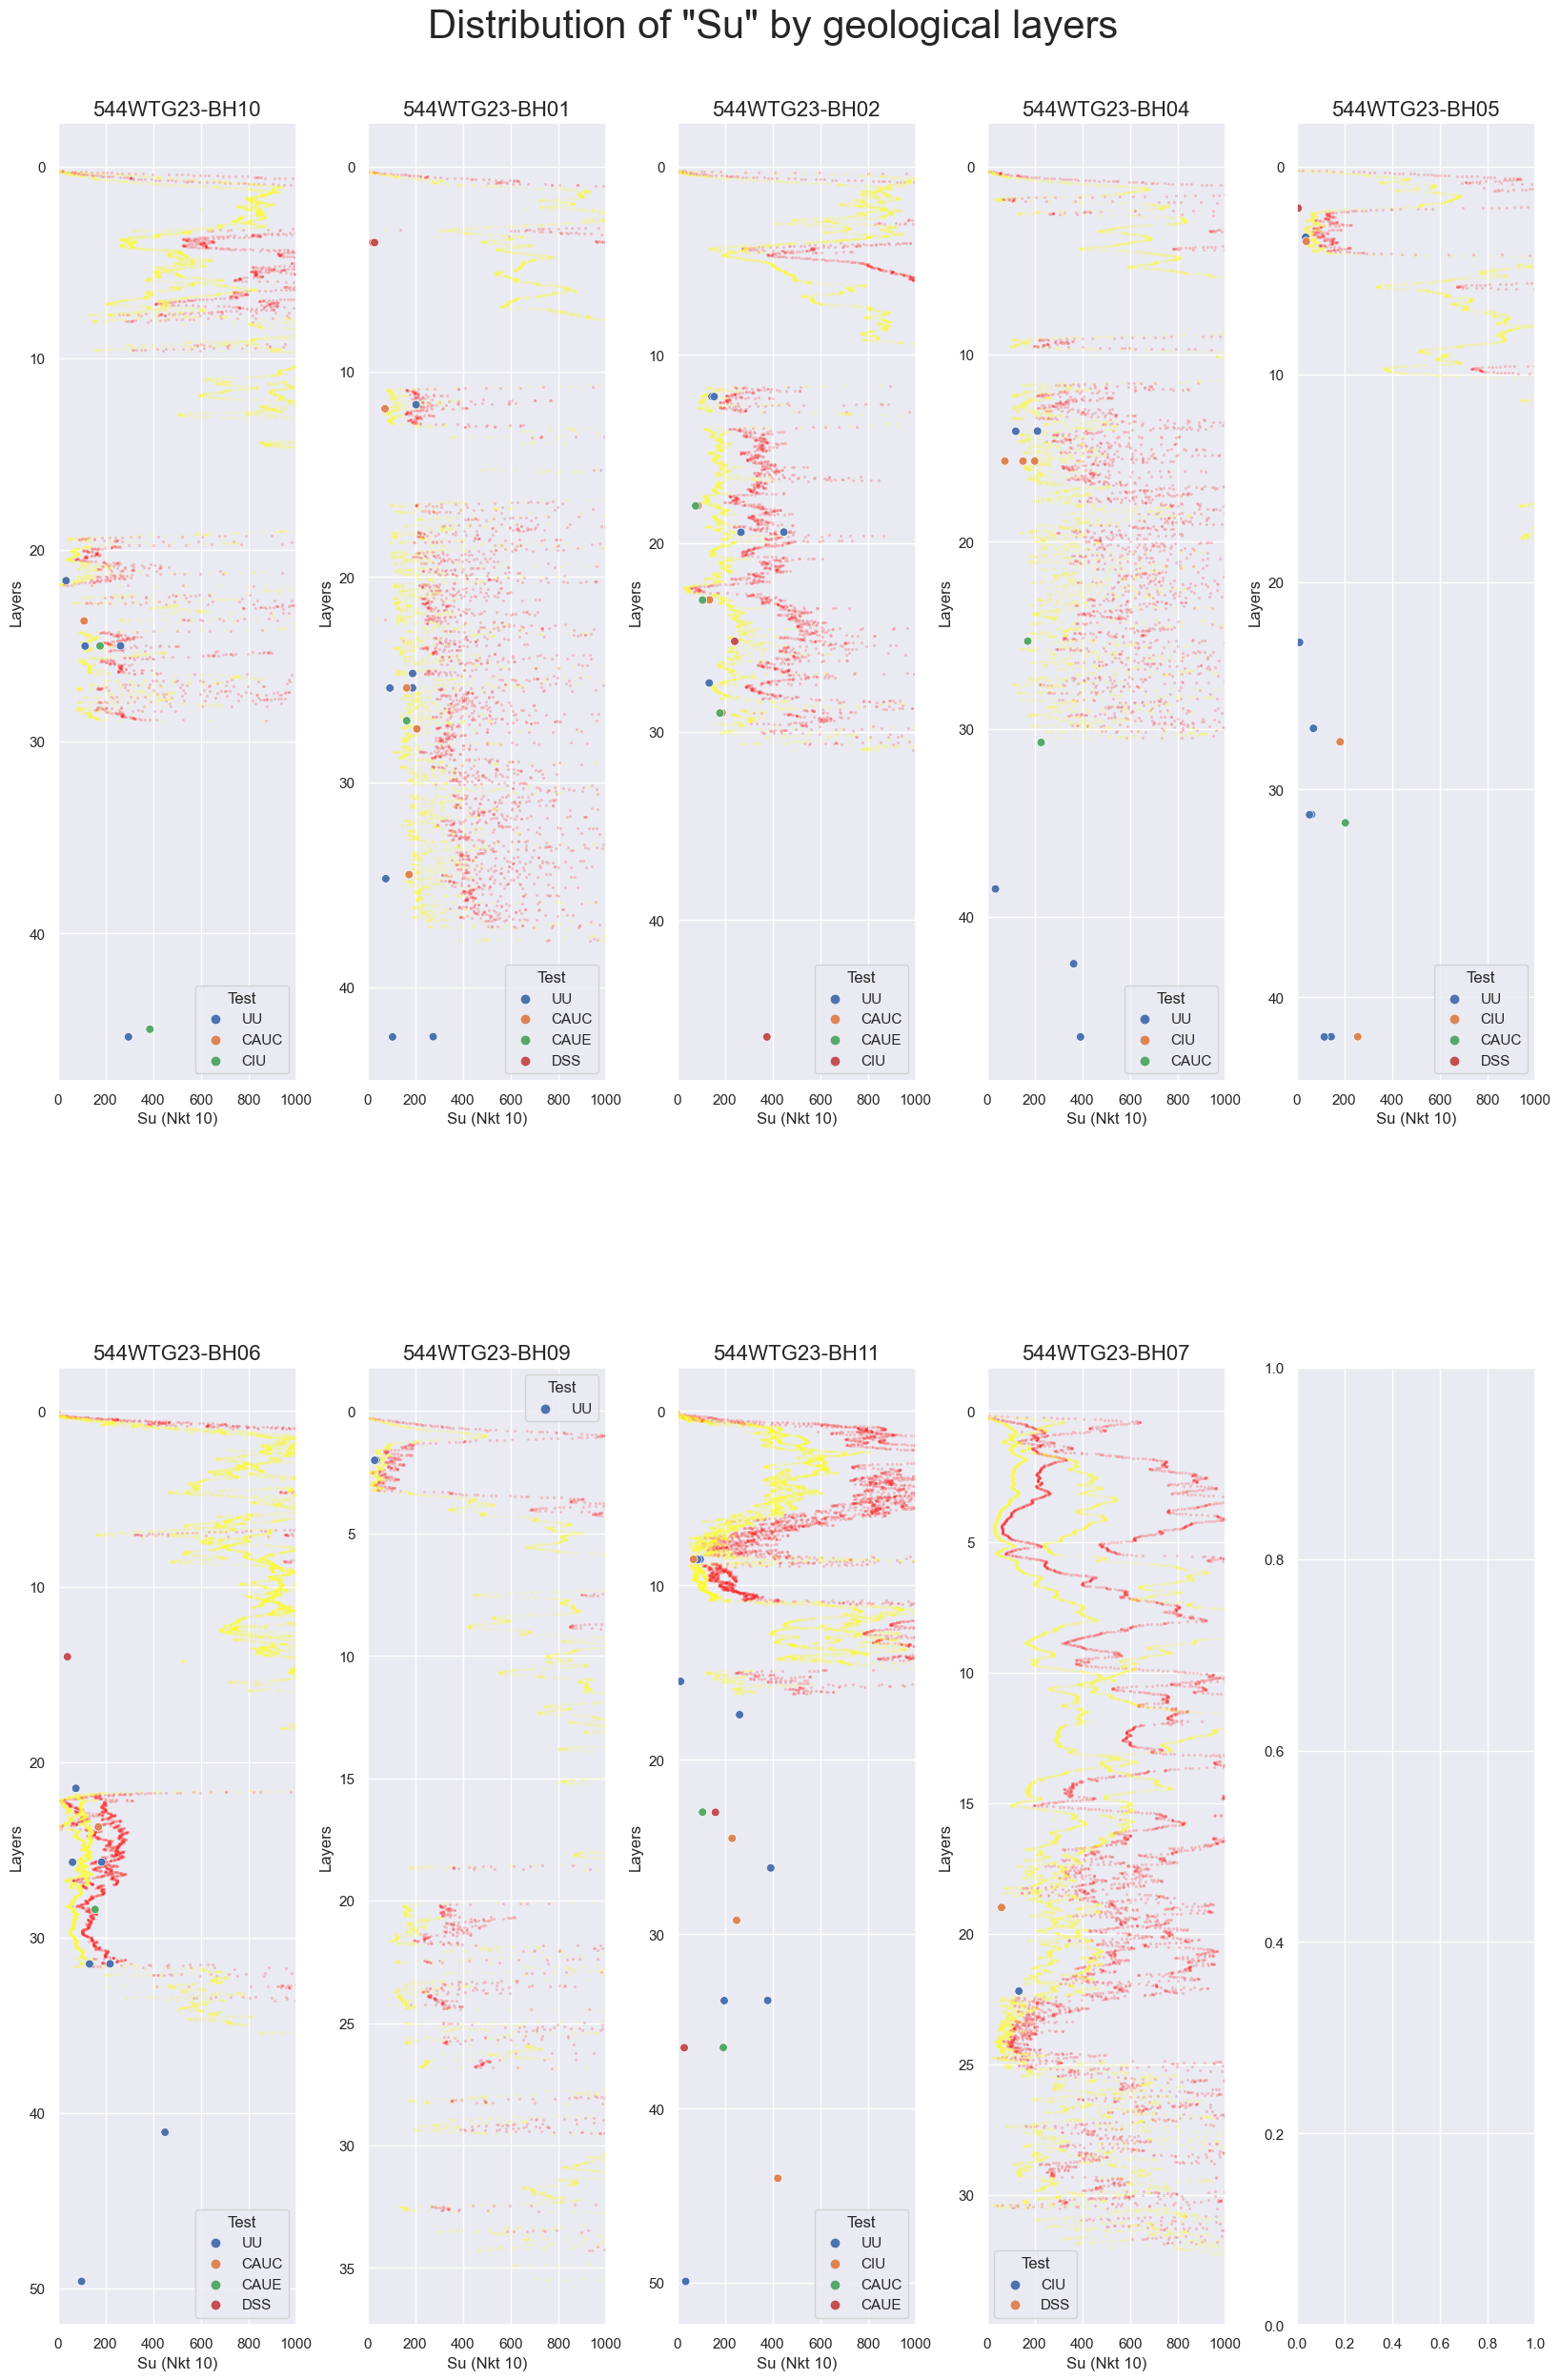

In [50]:
plot_df = cpt_df
borehole_list = plot_df["PointID"].unique()
bh = 0
fig, axes = plt.subplots(2, 5)
fig.suptitle(f'Distribution of "Su" by geological layers', size=30, x=0.5, y=0.92)
fig.subplots_adjust(hspace=0.3, wspace=0.3)
sns.set(rc={"figure.figsize":(20, 30)})
sns.set(font_scale=1) 
for row in range(2):
    for col in range(5):
        if bh >= len(borehole_list):
            pass
        else:
            filtered_df = plot_df[plot_df["PointID"] == borehole_list[bh]]
            fsu_df = su_df[su_df["PointID"] == borehole_list[bh]]
            ax = sns.scatterplot(data=filtered_df, x="Su (Nkt 10)", y="Depth (m)", alpha=0.2, ax=axes[row, col], s=5, color="red")
            ax = sns.scatterplot(data=filtered_df, x="Su (Nkt 20)", y="Depth (m)", alpha=0.2, ax=axes[row, col], s=5, color="yellow")
            ax = sns.scatterplot(data=fsu_df, x="Su", y="Depth", hue="Test", alpha=1, ax=axes[row, col], s=40)
            ax.set_title(borehole_list[bh], size=16)
            ax.set_ylabel("Layers")
            ax.invert_yaxis()
            ax.set_xlim(0, 1000)
            bh += 1

## Derive Nkt

In [51]:
def find_Nkt(cpt_df, bh, depth, cpt_su):
    df = cpt_df[cpt_df["PointID"] == bh]
    df = df[(df["Depth (m)"] < depth + 0.5) & (df["Depth (m)"] > depth - 0.5)]
    Nkt = (df["qnet (kPa)"].mean() - df["σv (kPa)"].mean()) / cpt_su
    return Nkt, df["qnet (kPa)"].mean() - df["σv (kPa)"].mean()

In [52]:
su_df["PointID"].unique()

array(['544WTG23-BH01', '544WTG23-BH02', '544WTG23-BH04', '544WTG23-BH05',
       '544WTG23-BH06', '544WTG23-BH09', '544WTG23-BH10', '544WTG23-BH11',
       '544WTG23-BH07', '544WTG23-BH08', '544WTG23-BH03'], dtype=object)

In [54]:
su_df[["Derived Nkt", "Qt"]] = su_df.apply(lambda x: find_Nkt(cpt_df, x.PointID, x.Depth, x.Su), axis=1, result_type="expand")
# su_df["Nkt check"] = su_df["Derived Nkt"].apply(lambda x: "In" if (x <= 20 and x > 10) else ("Mid" if (x < 25 and x > 10) else "Out"))
#su_df["Nkt check"] = su_df["Derived Nkt"].apply(lambda x: "In" if (x <= 20 and x > 10) else "Out")
su_df

,PointID,Depth,Su,Test,Derived Nkt,Qt
0,544WTG23-BH01,11.60,203.30,UU,14.277250,2902.565023
1,544WTG23-BH01,24.70,188.90,UU,47.070611,8891.638421
2,544WTG23-BH01,25.40,188.40,UU,40.048023,7545.047608
3,544WTG23-BH01,25.41,93.70,UU,79.836814,7480.709464
4,544WTG23-BH01,34.70,76.33,UU,65.169833,4974.413346
...,...,...,...,...,...,...
90,544WTG23-BH01,3.70,29.00,DSS,388.742776,11273.540517
91,544WTG23-BH03,18.50,32.00,DSS,NaN,NaN
92,544WTG23-BH05,2.00,6.00,DSS,1120.407826,6722.446959
93,544WTG23-BH06,14.00,40.00,DSS,510.972281,20438.891227


(0.0, 110.0)

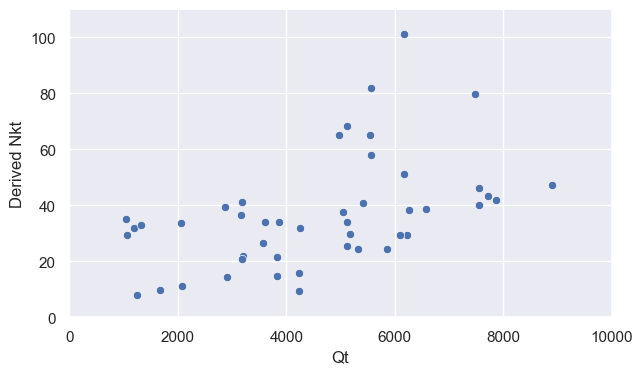

In [63]:
ax = sns.set(rc={"figure.figsize":(7, 4)})
ax = sns.scatterplot(data=su_df, x="Qt", y="Derived Nkt")
ax.set_xlim(0, 10000)
ax.set_ylim(0, 110)

(0.0, 110.0)

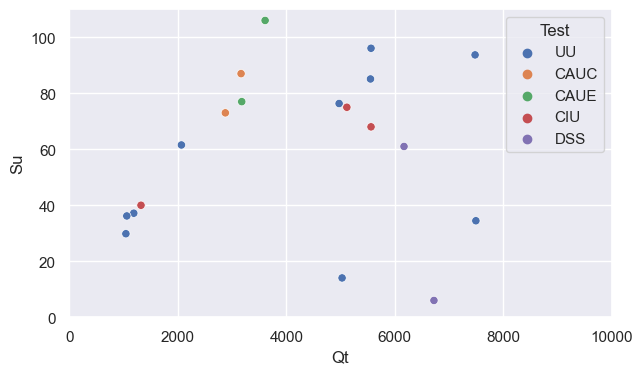

In [65]:
ax = sns.set(rc={"figure.figsize":(7, 4)})
ax = sns.scatterplot(data=su_df, x="Qt", y="Su", hue="Test")
ax.set_xlim(0, 10000)
ax.set_ylim(0, 110)

(0.0, 100.0)

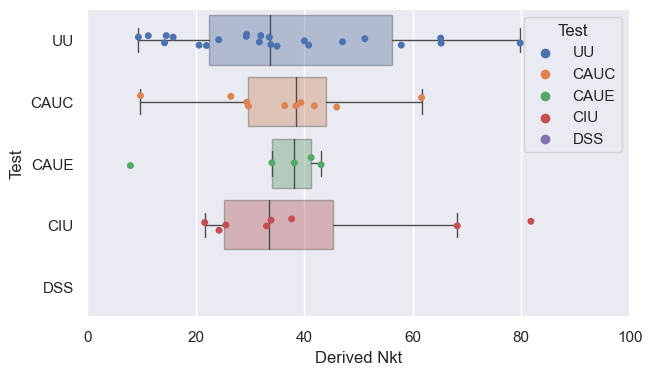

In [45]:
#plot_df = su_df[su_df["Nkt check"] == "In"]
sns.set(rc={"figure.figsize":(7, 4)})
sns.boxplot(data=su_df, x="Derived Nkt", y="Test", boxprops=dict(alpha=.4), linewidth=1, showfliers= False)
sns.stripplot(data=su_df, x="Derived Nkt", y="Test", orient="h", hue="Test").set_xlim(0, 100)

ValueError: Could not interpret value `Su (Nkt 10)` for parameter `x`

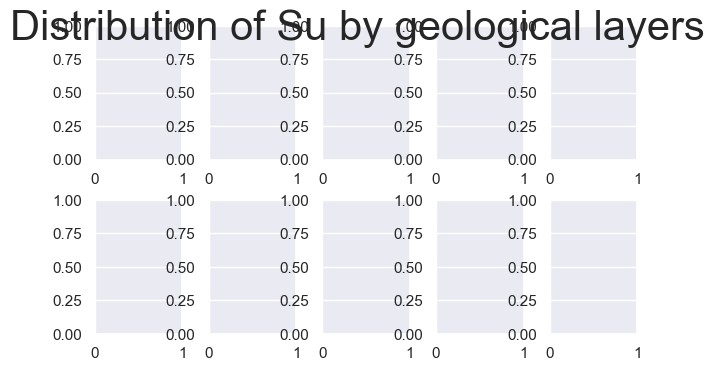

In [47]:
plot_df = cpt_df
xmin, xmax = 0, 1000
parameter = "Su"
############################
borehole_list = plot_df["PointID"].unique()
bh = 0
fig, axes = plt.subplots(2, 5)
fig.suptitle(f'Distribution of {parameter} by geological layers', size=30, x=0.5, y=0.92)
fig.subplots_adjust(hspace=0.3, wspace=0.3)
sns.set(rc={"figure.figsize":(20, 30)})
sns.set(font_scale=1) 
for row in range(2):
    for col in range(5):
        if bh >= len(borehole_list):
            pass
        else:
            filtered_df = plot_df[plot_df["PointID"] == borehole_list[bh]]
            fsu_df = su_df[su_df["PointID"] == borehole_list[bh]]
            ax = sns.scatterplot(data=filtered_df, x="Su (Nkt 10)", y="Depth (m)", alpha=0.5, ax=axes[row, col], color="tomato", s=10, label="Nkt=10")
            ax = sns.scatterplot(data=filtered_df, x="Su (Nkt 20)", y="Depth (m)", alpha=0.5, ax=axes[row, col], color="deepskyblue", s=10, label="Nkt=20")
            ax = sns.scatterplot(data=fsu_df, x=parameter, y="Depth", hue="Nkt check", marker="X", alpha=1, ax=axes[row, col], s=80,
                                palette=dict(Out="#9b59b6", In="#076928", Mid="#f20000"))
            # Plot geology
            bh_geo = geo_df[geo_df["PointID"] == borehole_list[bh]]
            for z in bh_geo["Depth"].to_list():
                    ax = sns.lineplot(x=[xmin, xmax], y=[z, z], ax=axes[row, col], alpha=0.3, color="navy", linestyle='dashed')
            ax.set_title(borehole_list[bh], size=16)
            ax.set_ylabel("Depth (m)")
            ax.set_xlabel("Su (kPa)")
            ax.invert_yaxis()
            ax.set_xlim(0, 1000)
            ax.legend()
            bh += 1

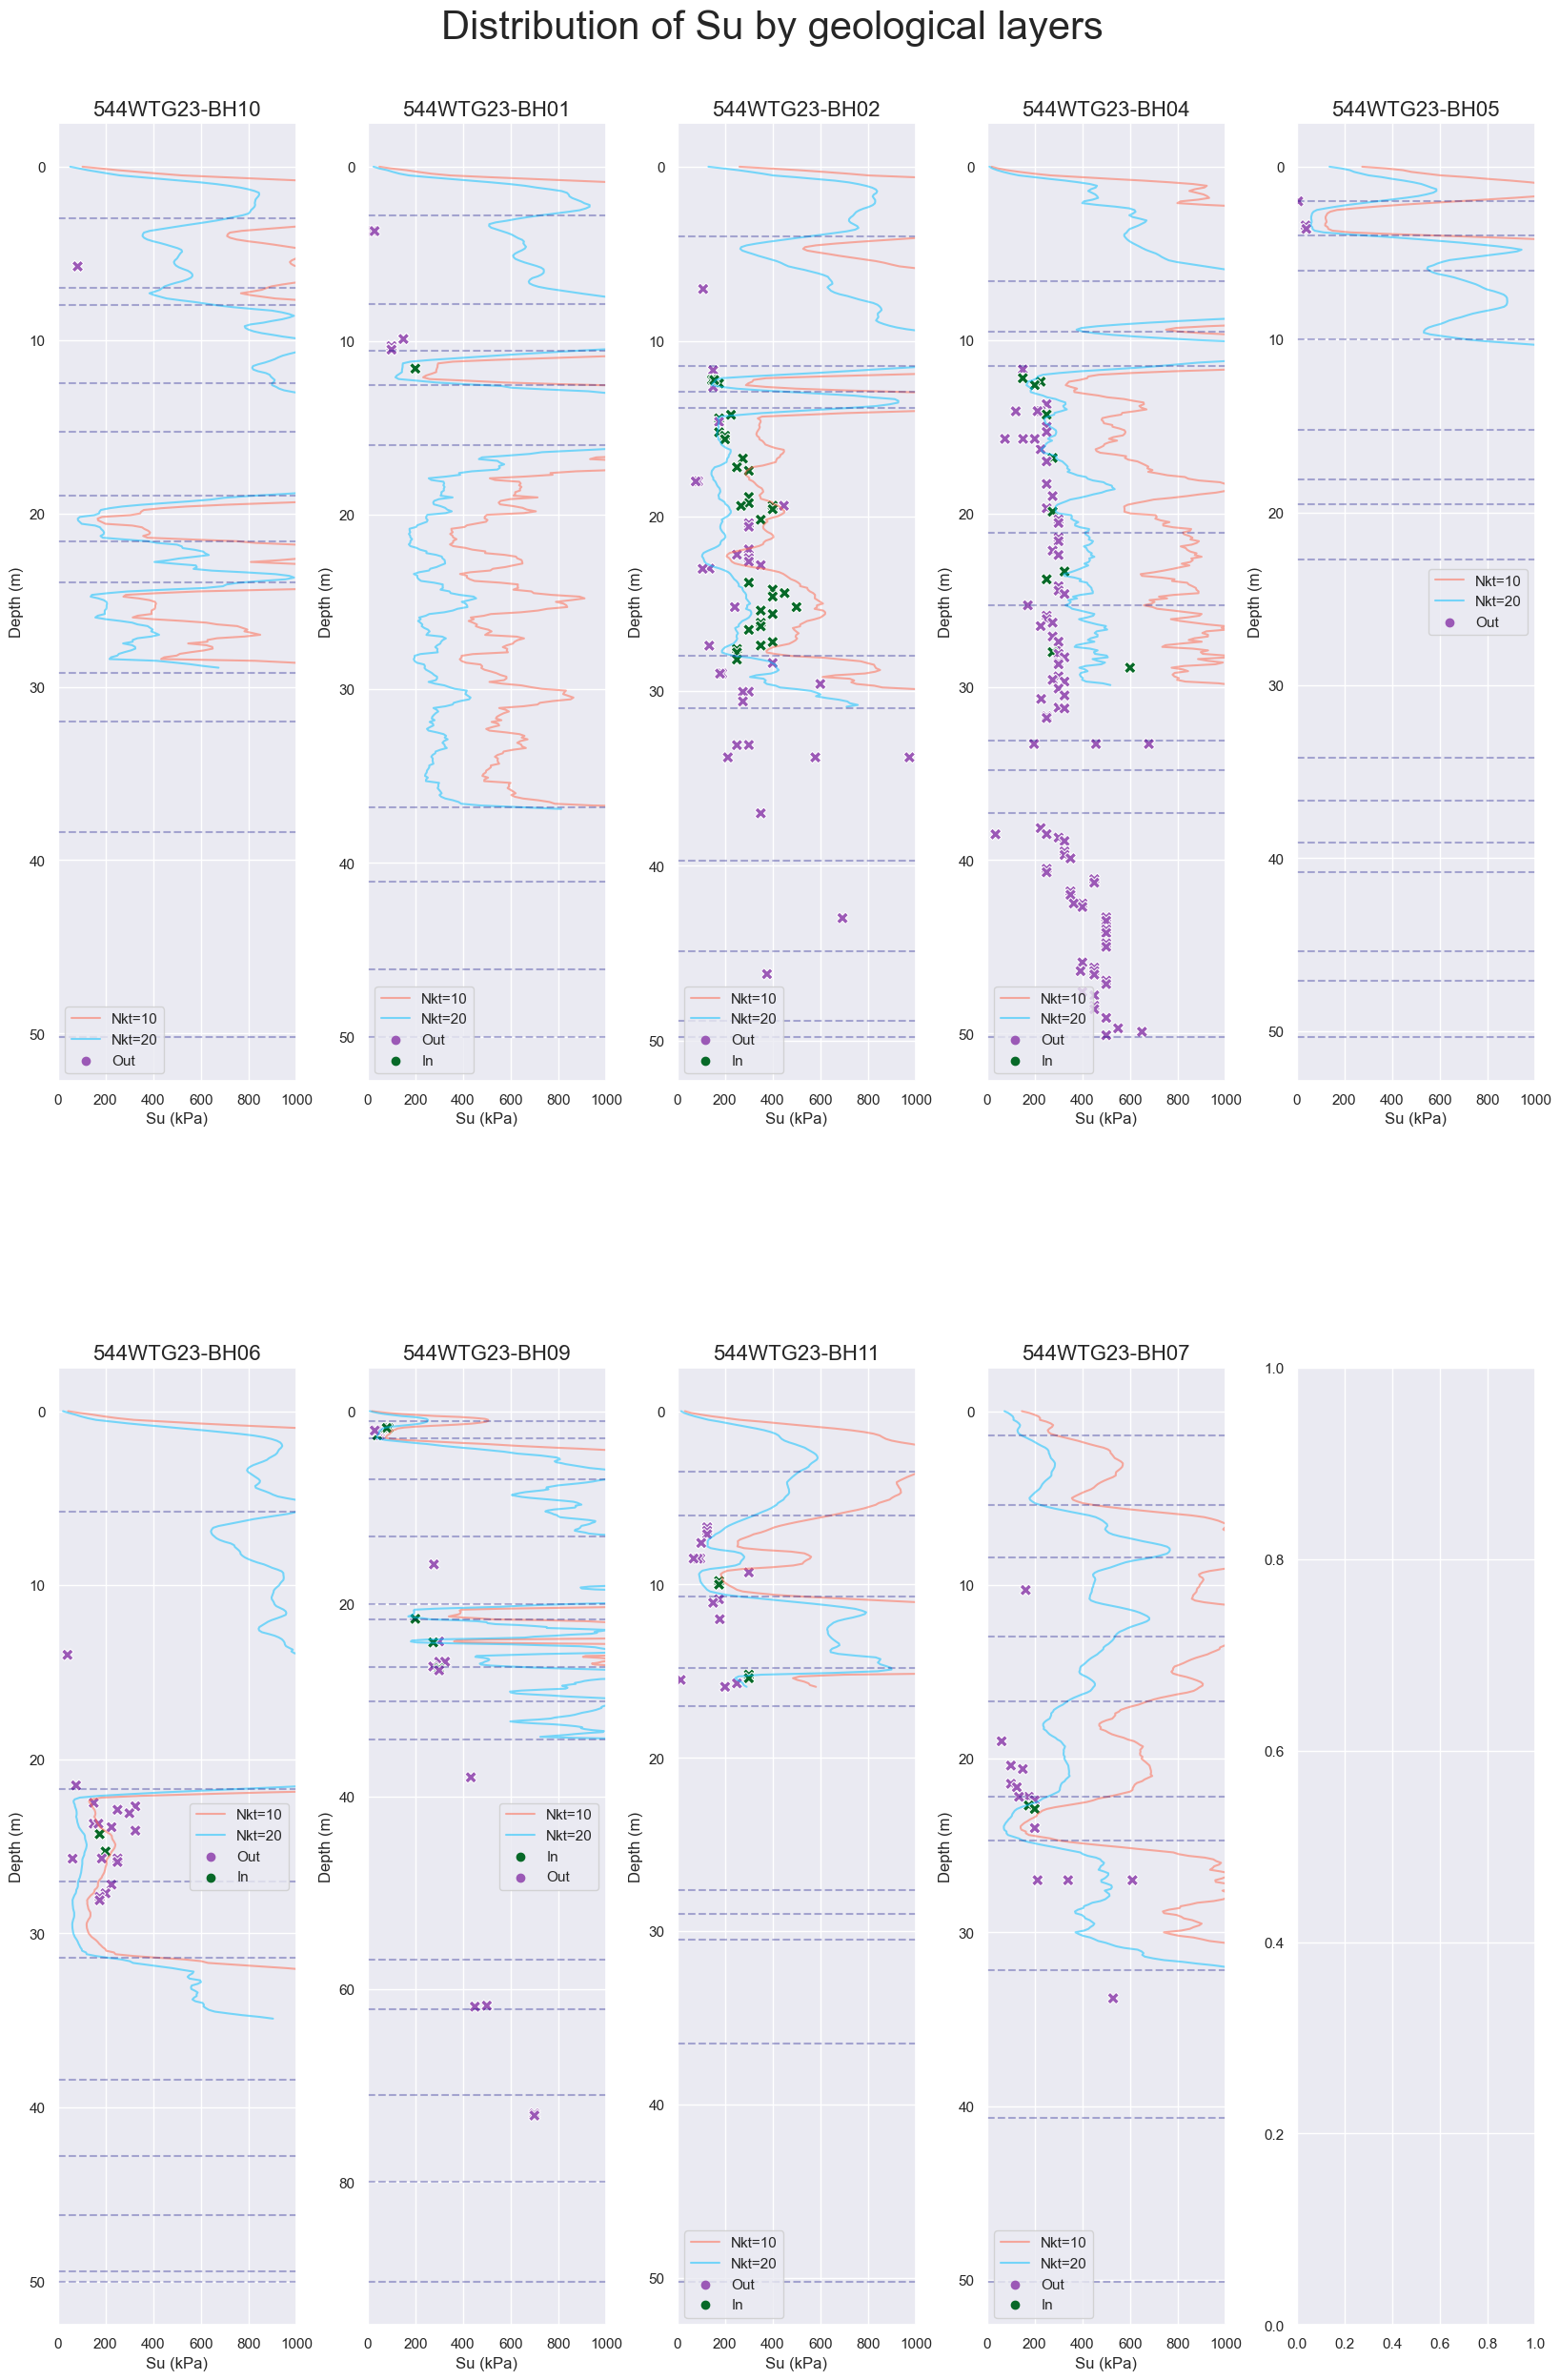

In [23]:
plot_df = su_mean
xmin, xmax = 0, 1000
############################
borehole_list = plot_df["PointID"].unique()
bh = 0
fig, axes = plt.subplots(2, 5)
fig.suptitle(f'Distribution of {parameter} by geological layers', size=30, x=0.5, y=0.92)
fig.subplots_adjust(hspace=0.3, wspace=0.3)
sns.set(rc={"figure.figsize":(20, 30)})
sns.set(font_scale=1) 
for row in range(2):
    for col in range(5):
        if bh >= len(borehole_list):
            pass
        else:
            filtered_df = plot_df[plot_df["PointID"] == borehole_list[bh]]
            fsu_df = su_df[su_df["PointID"] == borehole_list[bh]]
            ax = sns.lineplot(data=filtered_df, x="Su (Nkt 10)", y="Depth (m)", alpha=0.5, ax=axes[row, col], color="tomato", orient="y", label="Nkt=10")
            ax = sns.lineplot(data=filtered_df, x="Su (Nkt 20)", y="Depth (m)", alpha=0.5, ax=axes[row, col], color="deepskyblue", orient="y", label="Nkt=20")
            ax = sns.scatterplot(data=fsu_df, x=parameter, y="Depth", hue="Nkt check", marker="X", alpha=1, ax=axes[row, col], s=80,
                                palette=dict(Out="#9b59b6", In="#076928", Mid="#f20000"))
            # Plot geology
            bh_geo = geo_df[geo_df["PointID"] == borehole_list[bh]]
            for z in bh_geo["Depth"].to_list():
                    ax = sns.lineplot(x=[xmin, xmax], y=[z, z], ax=axes[row, col], alpha=0.3, color="navy", linestyle='dashed')
            ax.set_title(borehole_list[bh], size=16)
            ax.set_ylabel("Depth (m)")
            ax.set_xlabel("Su (kPa)")
            ax.invert_yaxis()
            ax.set_xlim(0, 1000)
            ax.legend()
            bh += 1

## Nkt statistics

Mean = 14.66
Median = 14.02


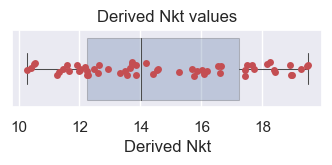

In [26]:
print("Mean =", round(su_df[su_df["Nkt check"] == "In"]["Derived Nkt"].mean(), 2))
print("Median =", round(su_df[su_df["Nkt check"] == "In"]["Derived Nkt"].median(), 2))
under25_df = su_df[su_df["Nkt check"] == "In"]
sns.set(rc={"figure.figsize":(4, 1)})
sns.stripplot(data=under25_df, x="Derived Nkt", c="r")
sns.boxplot(data=under25_df, x="Derived Nkt", boxprops=dict(alpha=.3), linewidth=.75, showfliers= False).set_title("Derived Nkt values")
# Seet value
derived_Nkt = su_df[su_df["Nkt check"] == "In"]["Derived Nkt"].mean()
cpt_df["Su (Nkt derived)"] =  (cpt_df["qnet (kPa)"] - cpt_df["σv (kPa)"]) / derived_Nkt

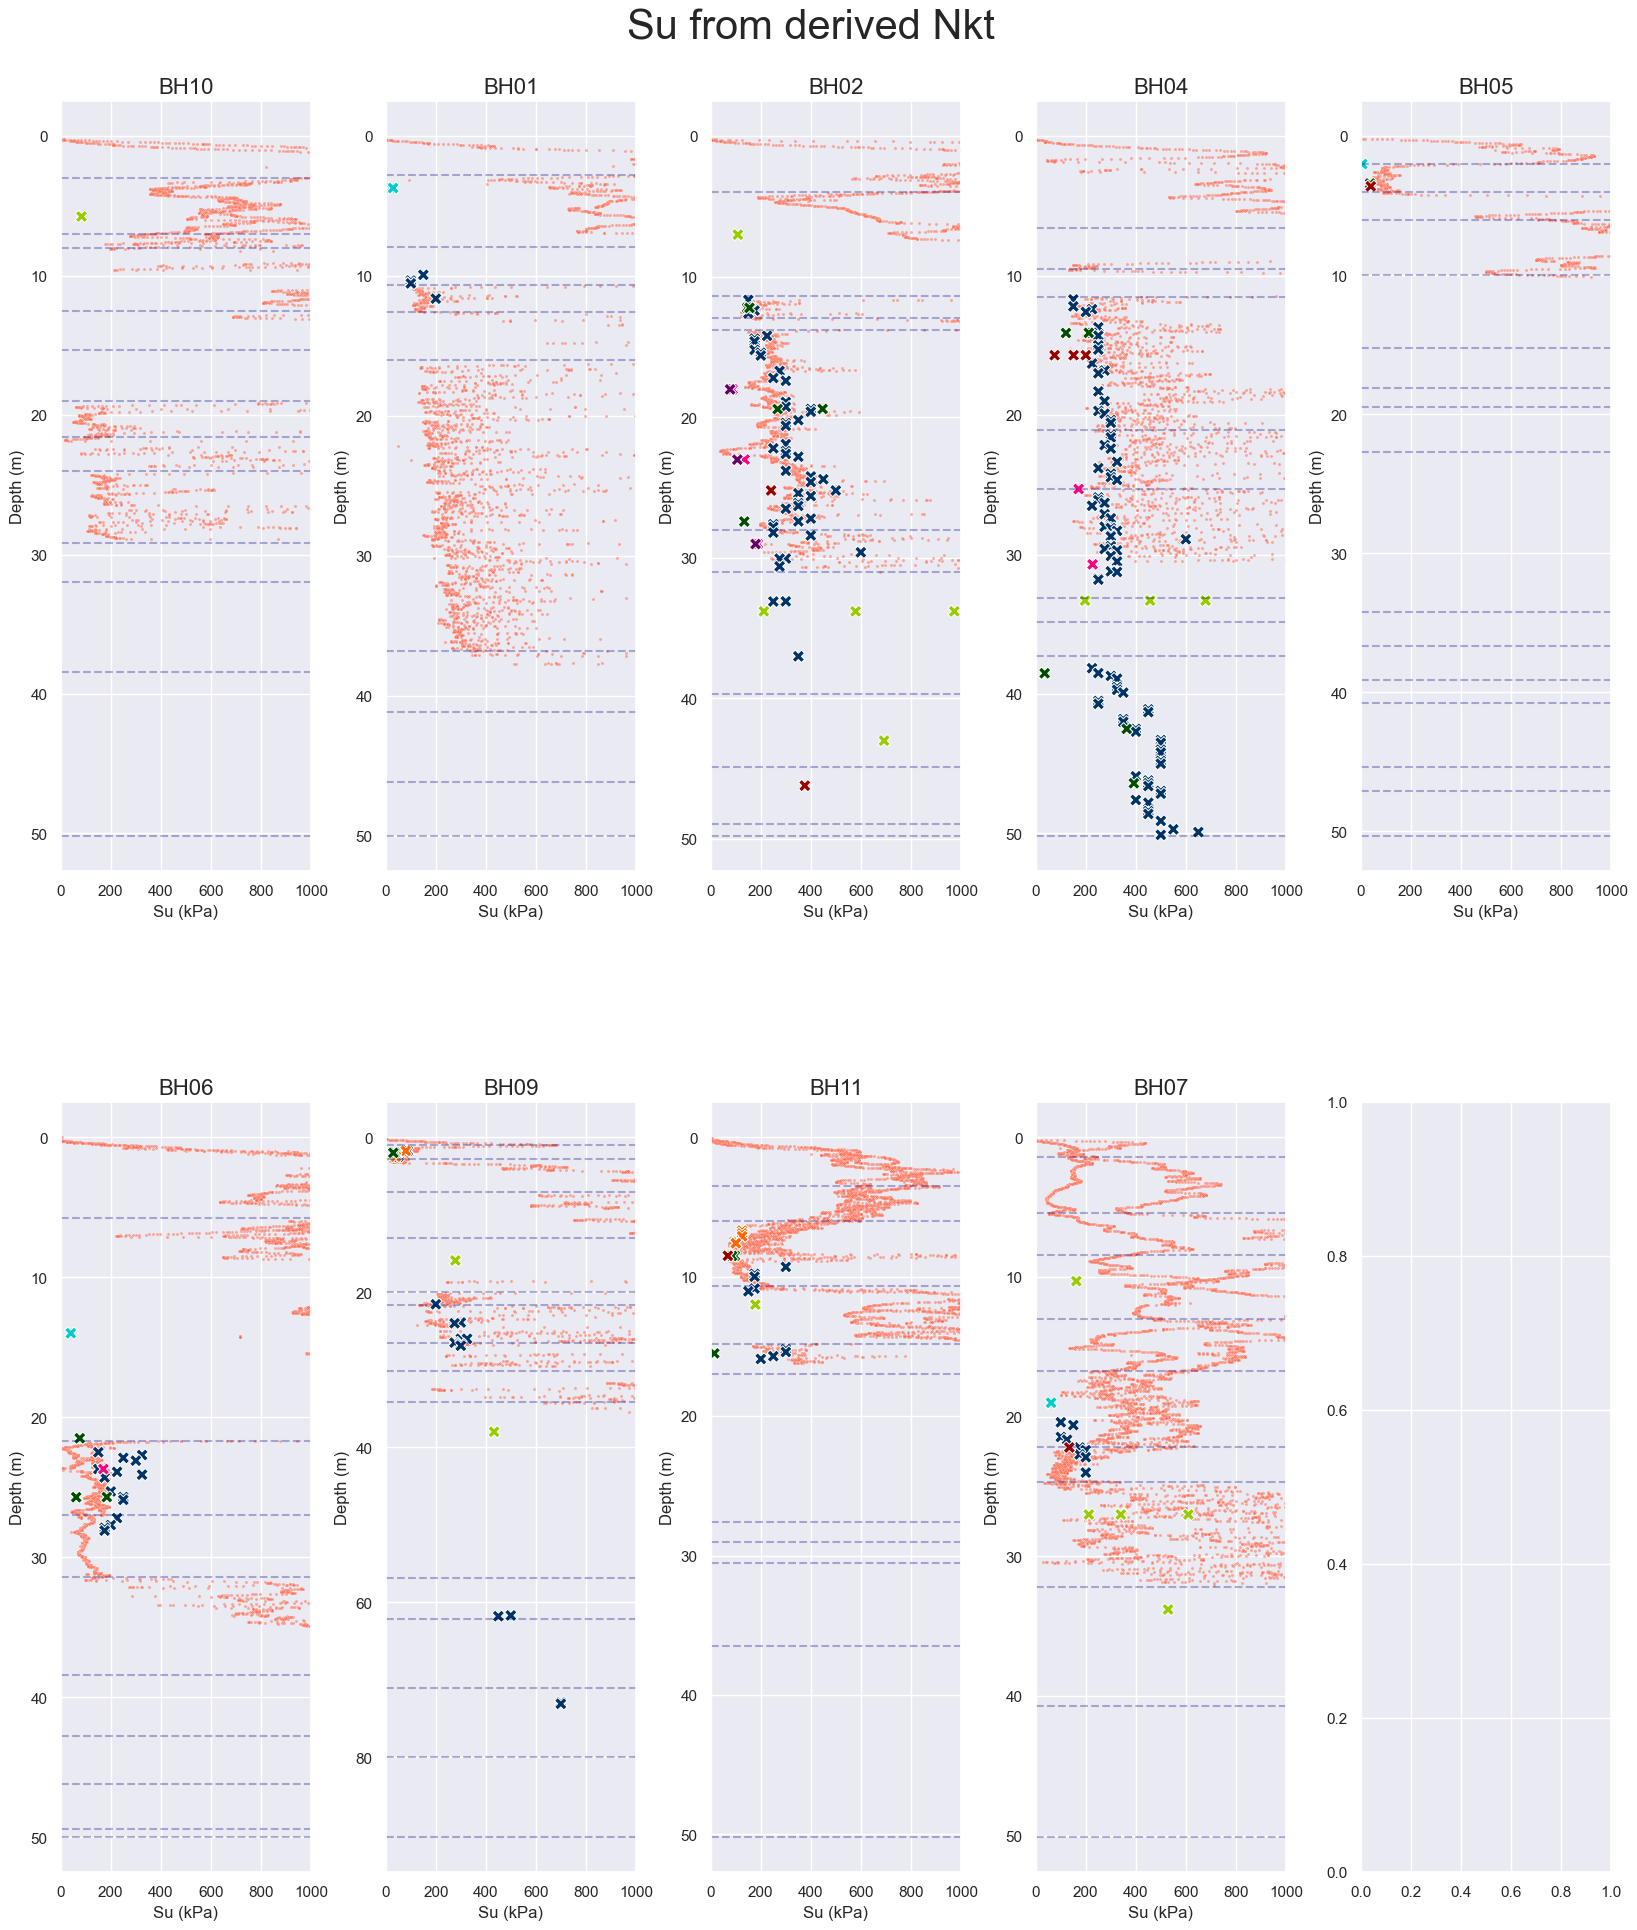

In [42]:
plot_df = cpt_df
xmin, xmax = 0, 1000
su_test_palette = {'LPEN': "#003366", 'TORV':"#ff6600", 'UU':"#004d00", 'CAUC':"#ff007f", 'CAUE':"#660066",
 'CID':"#99cc00", 'CIU':"#990000", 'DSS':"#00cccc"}
############################
borehole_list = plot_df["PointID"].unique()
bh = 0
fig, axes = plt.subplots(2, 5)
fig.suptitle(f"Su from derived Nkt", size=30, x=0.5, y=0.92)
fig.subplots_adjust(hspace=0.3, wspace=0.3)
sns.set(rc={"figure.figsize":(20, 23)})
sns.set(font_scale=1) 
for row in range(2):
    for col in range(5):
        if bh >= len(borehole_list):
            pass
        else:
            filtered_df = plot_df[plot_df["PointID"] == borehole_list[bh]]
            fsu_df = su_df[su_df["PointID"] == borehole_list[bh]]
            ax = sns.scatterplot(data=filtered_df, x="Su (Nkt derived)", y="Depth (m)", alpha=0.5, ax=axes[row, col], color="tomato", s=5)
            ax = sns.scatterplot(data=fsu_df, x=parameter, y="Depth", hue="Test", marker="X", alpha=1, ax=axes[row, col], s=80,
                                palette=su_test_palette, legend=False)
            #ax = sns.scatterplot(data=fsu_df, x=parameter, y="Depth", hue="Nkt check", marker="X", alpha=1, ax=axes[row, col], s=80,
                                #palette=dict(Out="#9b59b6", In="#076928", Mid="#f20000"))
 
            # Plot geology
            bh_geo = geo_df[geo_df["PointID"] == borehole_list[bh]]
            for z in bh_geo["Depth"].to_list():
                    ax = sns.lineplot(x=[xmin, xmax], y=[z, z], ax=axes[row, col], alpha=0.3, color="navy", linestyle='dashed')
            ax.set_title(borehole_list[bh][-4:], size=16)
            ax.set_ylabel("Depth (m)")
            ax.set_xlabel("Su (kPa)")
            ax.invert_yaxis()
            ax.set_xlim(0, 1000)
            #ax.legend()
            bh += 1

In [33]:
su_df["Test"].unique()

array(['LPEN', 'TORV', 'UU', 'CAUC', 'CAUE', 'CID', 'CIU', 'DSS'],
      dtype=object)

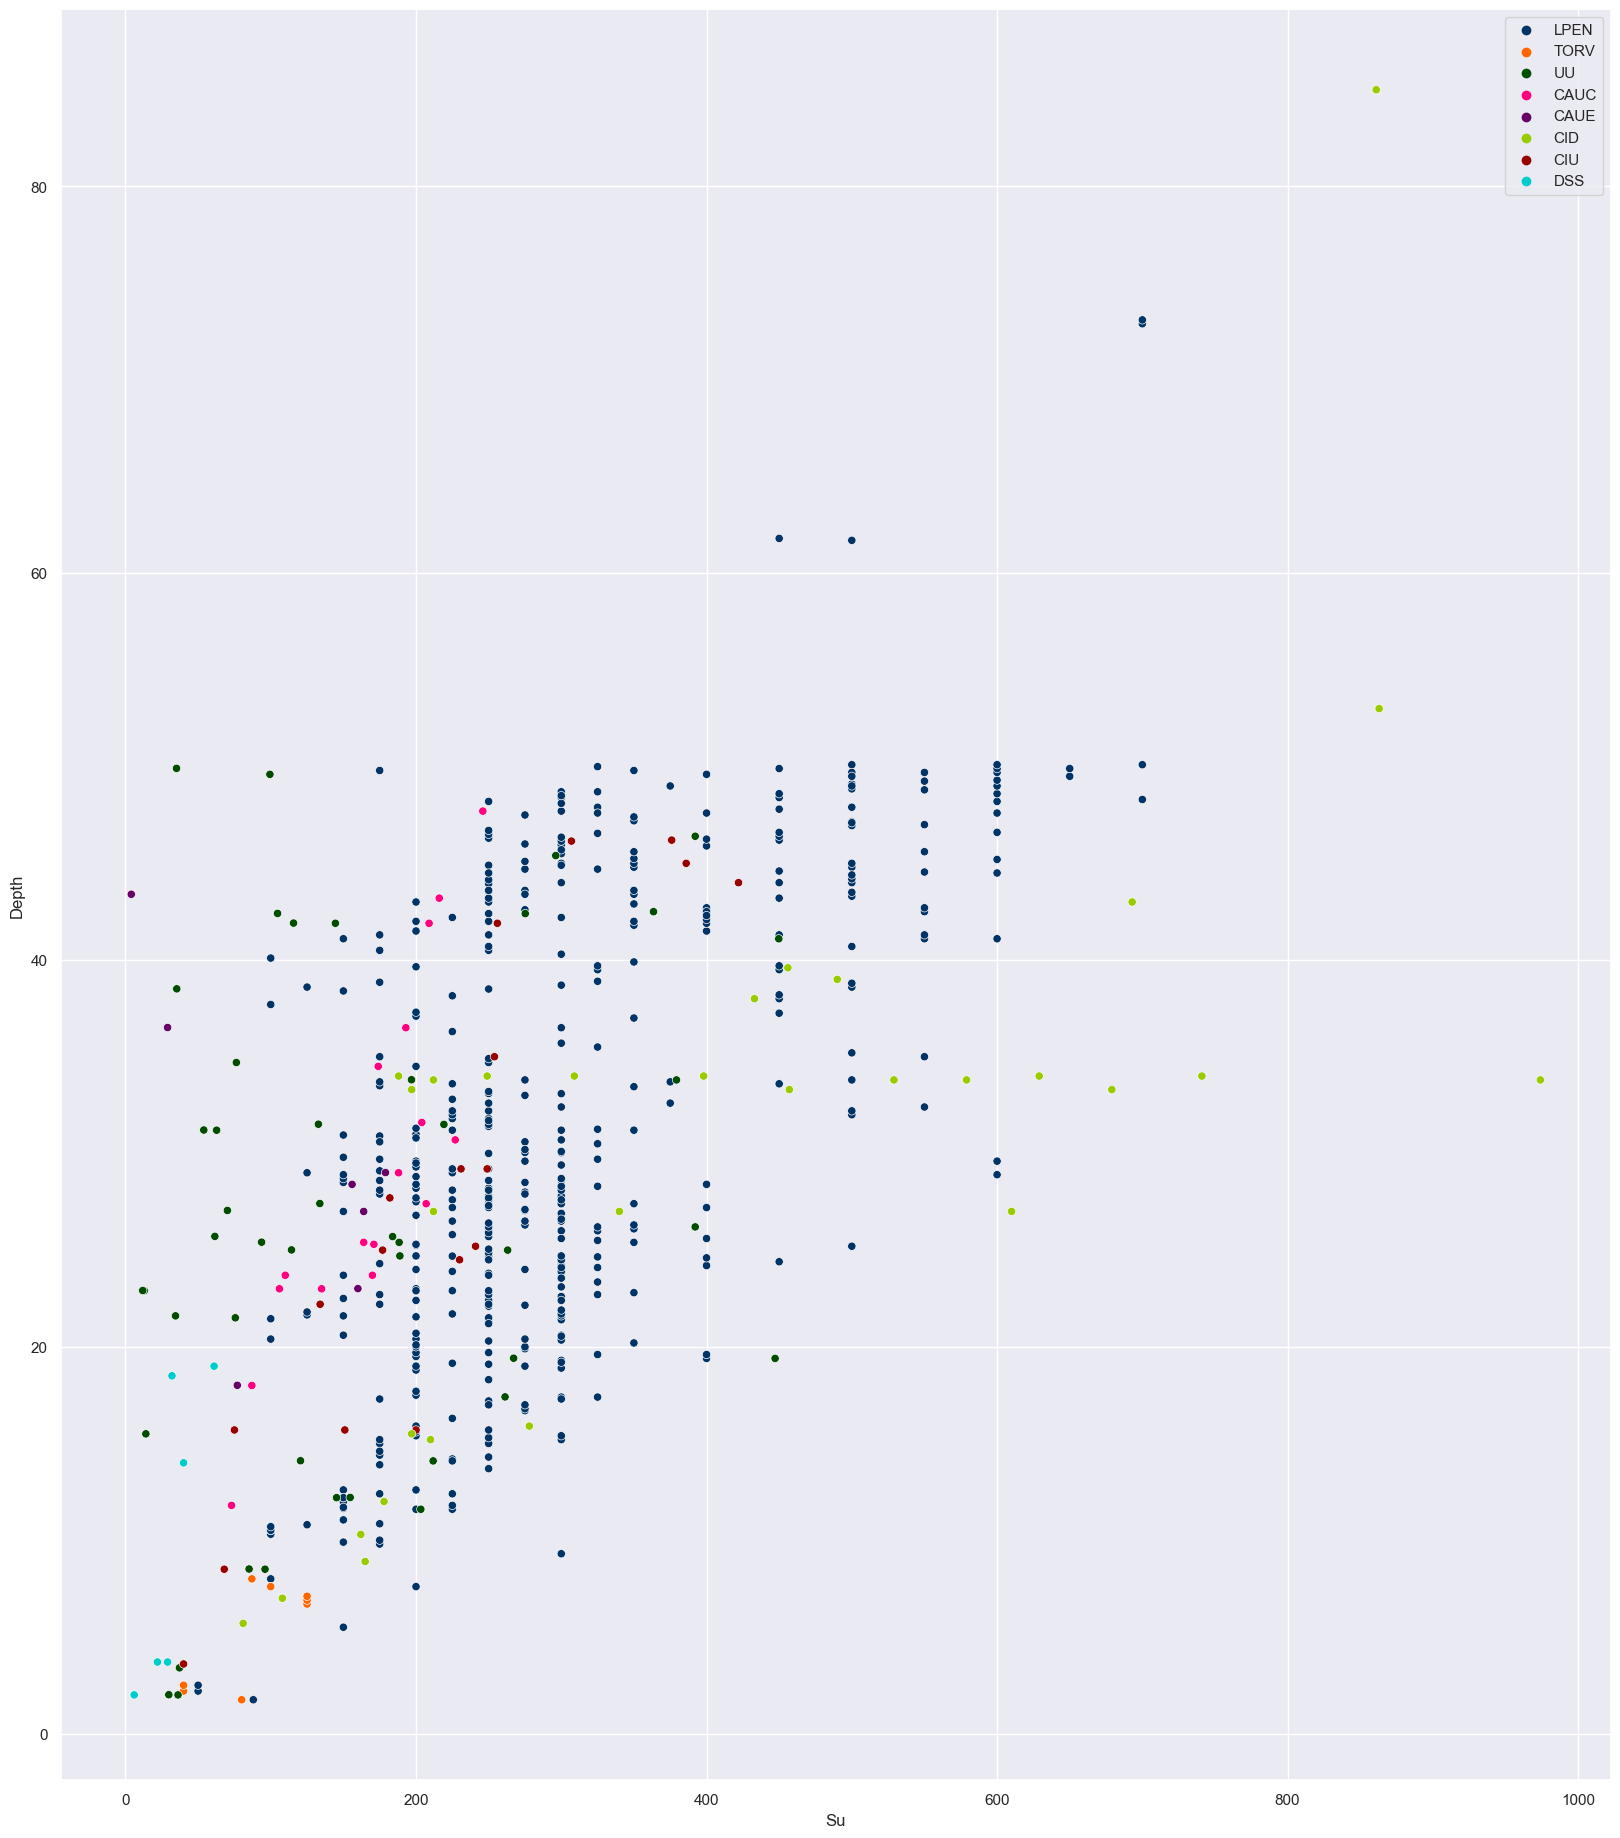

In [41]:
su_test_palette = {'LPEN': "#003366", 'TORV':"#ff6600", 'UU':"#004d00", 'CAUC':"#ff007f", 'CAUE':"#660066",
 'CID':"#99cc00", 'CIU':"#990000", 'DSS':"#00cccc"}
ax = sns.scatterplot(data=su_df, x="Su", y="Depth", hue="Test", palette=su_test_palette)
ax.legend()